In [1]:
from pathlib import Path   
import os                  

import numpy as np
import matplotlib.pyplot as plt
import cv2                # For image processing

# TensorFlow and Keras for deep learning
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn for data preprocessing and model evaluation
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical  # To convert a class vector (integers) to a binary class matrix
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def process_images_from_directory(directory, label, size):
    
    images_list = []
    for image_path in directory.iterdir():
        try:
            if image_path.suffix == '.png':
                # Read the image using OpenCV
                image = cv2.imread(str(image_path))

                # Convert the image to RGB (OpenCV uses BGR by default)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Resize the image
                image_resized = cv2.resize(image_rgb, (size, size))

                images_list.append(image_resized)
                label.append(0 if directory.name == 'Parasitized' else 1)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    return images_list

In [3]:
dataset_path_parasitized = Path("C:\\Users\\SaiSu\\Downloads\\archive (24)\\cell_images\\Parasitized")
dataset_path_uninfected  = Path("C:\\Users\\SaiSu\\Downloads\\archive (24)\\cell_images\\Uninfected")

In [4]:
SIZE      = 64    
dataset   = []    
label     = []    

dataset = process_images_from_directory(dataset_path_parasitized, label, SIZE)
dataset.extend(process_images_from_directory(dataset_path_uninfected, label, SIZE))

### Data Exploratory Analysis (EDA)


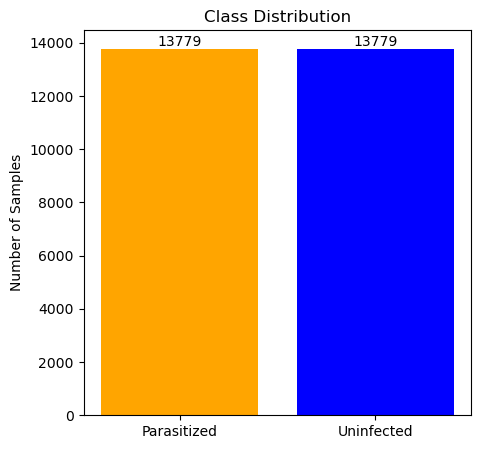

In [5]:
# Data for plotting
categories = ['Parasitized', 'Uninfected']
values     = [label.count(0), label.count(1)]
colors     = ['orange', 'blue']  

plt.figure(figsize = (5, 5))  
bars = plt.bar(categories, values, color = colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

plt.title('Class Distribution')
plt.ylabel('Number of Samples')

plt.show()

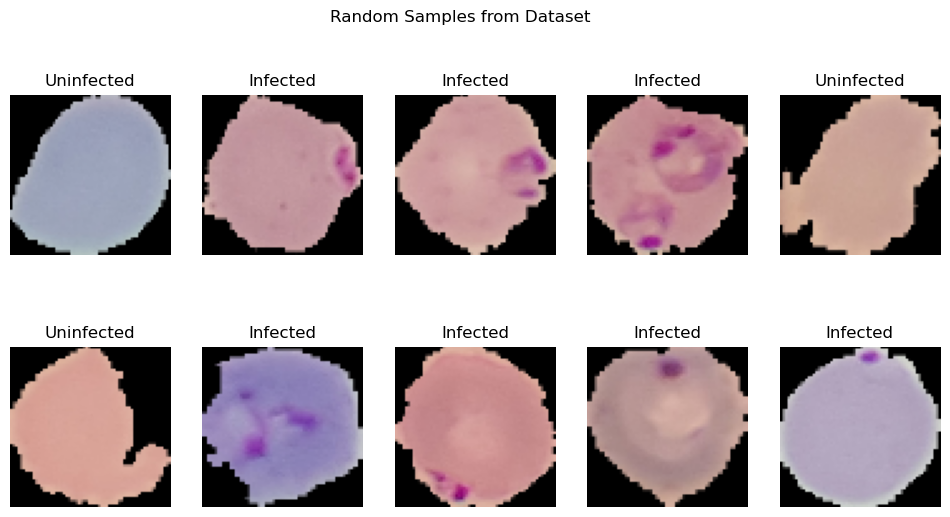

In [6]:
# Display some sample images:
def display_samples(samples, labels, title):
    plt.figure(figsize=(12, 6))
    for index, (image, label) in enumerate(zip(samples, labels)):
        plt.subplot(2, 5, index + 1)
        plt.imshow(image)
        plt.title('Infected' if label == 0 else 'Uninfected')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

samples_to_display = 10

random_indices = np.random.choice(len(dataset), samples_to_display, replace=False)
samples = [dataset[i] for i in random_indices]
sample_labels = [label[i] for i in random_indices]

display_samples(samples, sample_labels, "Random Samples from Dataset")

### Training & Validation

In [7]:
# Splitting the Dataset
X = np.array(dataset)
Y = to_categorical(np.array(label))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [8]:
# Data Augmentation
# Define the ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range    = 15,
    width_shift_range = 0.2,
    height_shift_range= 0.2,
    zoom_range        = 0.2,
    shear_range = 0.2,
    horizontal_flip   = True,
    vertical_flip     = True,
)

# to create the augmented data generator
augmented_data = data_generator.flow(X_train, y_train, batch_size = 64,shuffle = True)

In [9]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22046, 64, 64, 3)
y_train shape: (22046, 2)
X_test shape: (5512, 64, 64, 3)
y_test shape: (5512, 2)


### Inceptionv3

In [10]:
import keras
from keras.applications import InceptionV3
from keras.regularizers import l2
import cv2

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical

def preprocess_image(image):
    # Resize image to 75x75 pixels
    resized_image = tf.image.resize(image, (75, 75))
    # Normalize pixel values to the range [0, 1]
    resized_image = resized_image / 255.0
    return resized_image

def dense_block(input_tensor, num_neurons):
    x = layers.Dense(num_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    return x

# Load the InceptionV3 model without the top (classification) layers
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Freeze the convolutional layers to prevent training
for layer in inception.layers:
    layer.trainable = False

# Define a preprocessing layer for the input images
input_layer = layers.Input(shape=(None, None, 3))
preprocessing_layer = layers.Lambda(preprocess_image)(input_layer)

# Pass the preprocessed input through the InceptionV3 base
x = inception(preprocessing_layer)

# Add GlobalAveragePooling2D layer to replace Flatten layer
x = layers.GlobalAveragePooling2D()(x)

# Add dense layers
x = dense_block(x, 512)
x = dense_block(x, 256)

# Output layer
out = layers.Dense(2, activation='sigmoid')(x)


In [25]:

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=out)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Print model summary
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 lambda (Lambda)             (None, 75, 75, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_478 (B  (None, 512)               2048      
 atchNormalization)                                        

In [26]:
# Training the Model without Early Stopping
history = model.fit(
    augmented_data,
    verbose=1,
    epochs=45,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 64  # Number of batches per epoch
)

Epoch 1/45
344/344 [==============================] - 235s 586ms/step - loss: 1.1103 - accuracy: 0.8116 - val_loss: 0.7391 - val_accuracy: 0.8719
Epoch 2/45
344/344 [==============================] - 163s 473ms/step - loss: 0.6900 - accuracy: 0.8310 - val_loss: 0.6516 - val_accuracy: 0.7968
Epoch 3/45
344/344 [==============================] - 180s 520ms/step - loss: 0.5350 - accuracy: 0.8406 - val_loss: 0.4864 - val_accuracy: 0.8474
Epoch 4/45
344/344 [==============================] - 76s 221ms/step - loss: 0.4825 - accuracy: 0.8351 - val_loss: 0.5945 - val_accuracy: 0.7612
Epoch 5/45
344/344 [==============================] - 81s 236ms/step - loss: 0.4530 - accuracy: 0.8397 - val_loss: 0.4360 - val_accuracy: 0.8443
Epoch 6/45
344/344 [==============================] - 87s 253ms/step - loss: 0.4513 - accuracy: 0.8338 - val_loss: 0.4432 - val_accuracy: 0.8353
Epoch 7/45
344/344 [==============================] - 88s 256ms/step - loss: 0.4424 - accuracy: 0.8355 - val_loss: 0.4919 - val

In [27]:
# Evaluate the model
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(f"Test Loss: {scores[0]:.5f}")

# Predict classes with the model
predictions = model.predict(np.array(X_test))
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to single-column format
y_test_single_column = np.argmax(y_test, axis=1)

# Generate classification report and confusion matrix
print(classification_report(y_test_single_column, predicted_classes))
print(confusion_matrix(y_test_single_column, predicted_classes))

Accuracy: 86.47%
Test Loss: 0.35429
173/173 [==============================] - 28s 122ms/step
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      2703
           1       0.82      0.95      0.88      2809

    accuracy                           0.86      5512
   macro avg       0.87      0.86      0.86      5512
weighted avg       0.87      0.86      0.86      5512

[[2111  592]
 [ 154 2655]]


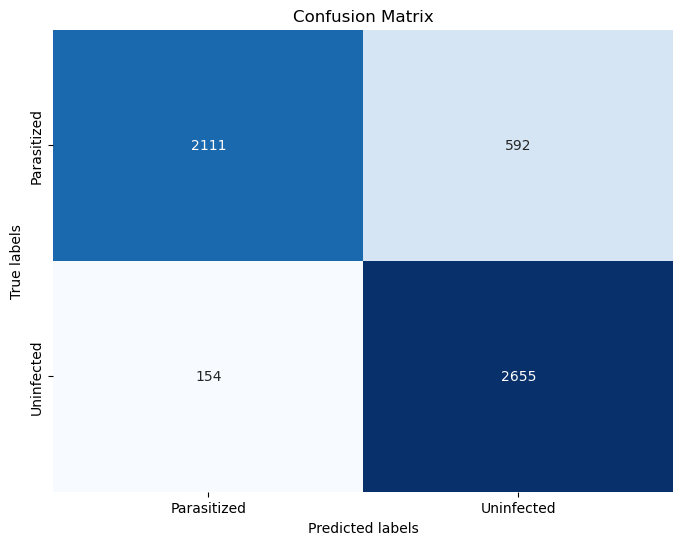

In [28]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_single_column, predicted_classes)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.show()

In [29]:
# Calculate the average training loss over all epochs
average_train_loss = np.mean(history.history['loss'])

# Get the training loss from the last epoch
final_train_loss = history.history['loss'][-1]

print(f"Average Training Loss: {average_train_loss:.5f}")
print(f"Final Training Loss: {final_train_loss:.5f}")

Average Training Loss: 0.43425
Final Training Loss: 0.39508


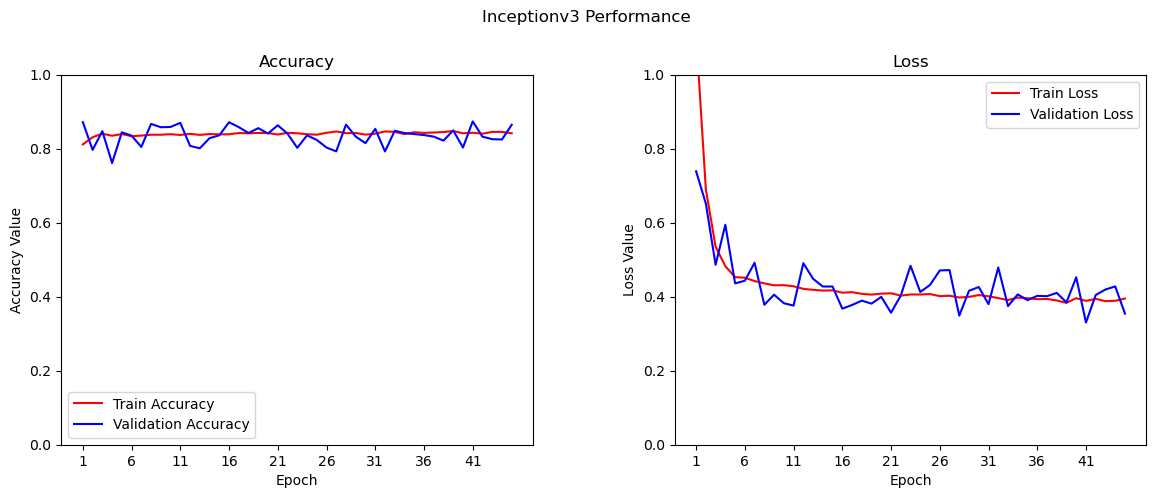

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Inceptionv3 Performance', fontsize=12)
    fig.subplots_adjust(top=0.85, wspace=0.3)

    # Extract the number of epochs and create a list of epoch numbers
    max_epoch = len(history.history['accuracy'])
    epoch_list = list(range(1, max_epoch + 1))

    # Plot training and validation accuracy
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy', color='red')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy', color='blue')
    ax1.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    ax1.legend(loc="best")
    ax1.set_ylim([0, 1])  # Set y-axis limits to [0, 1]

    # Plot training and validation loss
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss', color='red')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss', color='blue')
    ax2.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    ax2.legend(loc="best")
    ax2.set_ylim([0, 1])  # Set y-axis limits to [0, 1]

    # Display the plots
    plt.show()

# Call the function to plot
plot_training_history(history)
